In [1]:
# !python.exe -m pip install --upgrade pip
# !pip3 install pigar -q
import pigar

In [2]:
import numpy as np
import pandas as pd
import torch

# from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib as pl

In [3]:
# !pigar generate
!pip3 install -r requirements.txt -q

In [4]:
DFN = 'data'

In [5]:
def load(csv_fn: str, location: pl.Path =pl.Path('./').joinpath(DFN), **pdkwargs) -> pd.DataFrame:
    """loads CSV file to pandas DataFrame if it exists"""
    try:
        with open(fp := location.joinpath(csv_fn), 'r') as f:
            result = pd.read_csv(f, **pdkwargs)
            print(f"{fp.stat().st_size / 2 ** 20:.3f}MB csv file {fp} has been loaded successfully")
        return result
    except FileNotFoundError:
        print(f"file {csv_fn} doesn't exist")
        return None

In [386]:
train_df = load('problem_train.csv', low_memory=False)
test_df = load('problem_test.csv', low_memory=False)
labels_df = load('problem_labels.csv')

14.085MB csv file data\problem_train.csv has been loaded successfully
3.539MB csv file data\problem_test.csv has been loaded successfully
0.263MB csv file data\problem_labels.csv has been loaded successfully


In [7]:
# everything (except auto-indexing as object) is treated as int64
labels_df.dtypes.unique(), labels_df.shape, labels_df.select_dtypes(include=['int64']).columns.size

(array([dtype('int64')], dtype=object), (8000, 15), 15)

In [8]:
labels_df

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,10898,1,1,1,0,0,0,1,0,0,1,1,1,1,1
7996,16664,0,0,0,0,0,0,0,0,0,1,1,0,0,0
7997,5334,1,0,0,0,0,0,0,0,0,1,1,0,0,0
7998,7905,1,1,1,0,0,0,0,0,0,1,1,0,0,0


# Preprocessing intro
First of all, task provides 0 domain knowledge, I have no idea what's behind that data

There is a lot of missing values and only 32 columns do not contain any missing data. Amongst those lies the 'id' column that must be discarded as all samples are considered IID and their order must not matter

Data has both categorical and numerical (integer and float) features

In [508]:
# we've inferred text, float and integer dtypes from train data
train_df.dtypes.unique()
# type O means strings, pandas stores pointers to strings (python objects) instead of strings themselves 
train_df.select_dtypes(include=['O']).columns.size, train_df.select_dtypes(include=['float64']).columns.size, train_df.select_dtypes(include=['int64']).columns.size

(1025, 345, 9)

In [509]:
sum((1025, 345, 9)) == train_df.columns.size

True

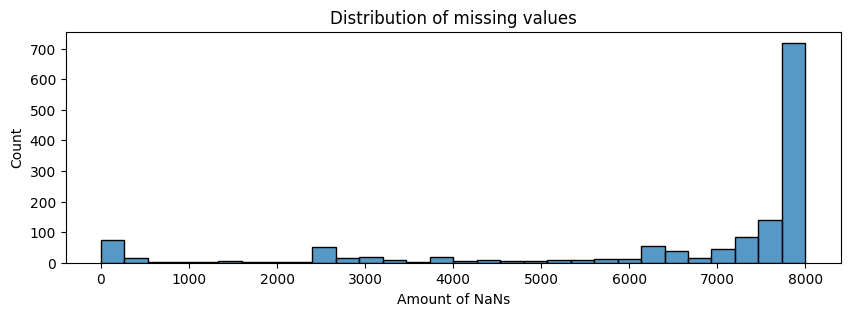

In [510]:
# missing values per column
fig, ax = plt.subplots(figsize=(10,3)) 
plt.title('Distribution of missing values')
plt.xlabel('Amount of NaNs')
ax = sns.histplot(train_df.isnull().sum(axis=0), ax=ax)

## NaN treatment
Since every row contains NaN values in at least 1 column, we can't just drop those and there is no rows with all NaNs (even w/o id and release columns)

Nevertheless, there are 30 columns with NaN only values that must be discarded (unless test data contains those -- and it doesn't)

In [170]:
# rows with at least 1 NaN
train_df[train_df.isnull().any(axis=1)].shape[0]

8000

In [171]:
# columns without NaNs
train_df[train_df.columns[~train_df.isnull().any(axis=0)]].shape[1]

32

In [172]:
# columns with all NaNs
allnan_cols = train_df.columns[train_df.isnull().all(axis=0)]
# ensures that train and test data have identical all-NaN columns
(test_df.columns[train_df.isnull().all(axis=0)] == train_df.columns[train_df.isnull().all(axis=0)]).all(), allnan_cols.shape[0]
# train_df[allnan_cols]

(True, 30)

## Integer part
It contains just 9 columns without any missing values. Nothing to do here, just note that 'id' column has to be discarded

In [185]:
int_part = train_df.select_dtypes(include=['int64'])
int_part.describe()

,id,n_0047,n_0050,n_0052,n_0061,n_0075,n_0091,o_0176,o_0264
count,8000.000000,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.000000,8000.000000
mean,9220.303375,1.0,1.0,1.0,1.0,1.0,1.0,198.395500,4.585875
std,5236.897900,0.0,0.0,0.0,0.0,0.0,0.0,118.487761,2.237912
min,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000
25%,4773.500000,1.0,1.0,1.0,1.0,1.0,1.0,92.000000,4.000000
50%,9221.500000,1.0,1.0,1.0,1.0,1.0,1.0,193.000000,5.000000
75%,13702.750000,1.0,1.0,1.0,1.0,1.0,1.0,315.000000,6.000000
max,18302.000000,1.0,1.0,1.0,1.0,1.0,1.0,369.000000,10.000000


## String part
Treated as categorical features, contains 1025 sparse columns with latin letters (33 lowercase latin letters, the only unique string value amongst top-50 columns is "**p**") and many missing values

It's not clearly ordinal (doesn't have any strong order except an alphabetical) and should be (ideally) one-hot-encoded (columnwise) as it doesn't bring any semantic meaning

Nevertheless, I don't want to blow up feature amount with OHE or discard features even with 99% of NaNs (like **o_0320**) at this stage, that's why i am going to implement ordinal encoding for all categorical features while treating NaNs as a separate entity (encoded as -1 by pd.factorize)

In [202]:
string_part = train_df.select_dtypes(include=['O'])
string_stats = string_part.describe()
string_stats

,release,c_0327,c_0328,c_0329,c_0330,c_0331,c_0332,c_0333,c_0334,c_0335,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
count,8000,22,512,5,157,6,1690,482,26,821,...,3,48,377,2,7998,440,3155,563,7,1908
unique,3,2,5,4,6,3,2,2,9,5,...,3,11,3,2,2,5,24,19,2,2
top,a,a,d,e,c,c,a,b,i,b,...,d,m,b,c,a,c,b,j,b,b
freq,3838,12,248,2,68,4,1498,383,15,468,...,1,22,312,1,7460,167,1559,232,4,1441


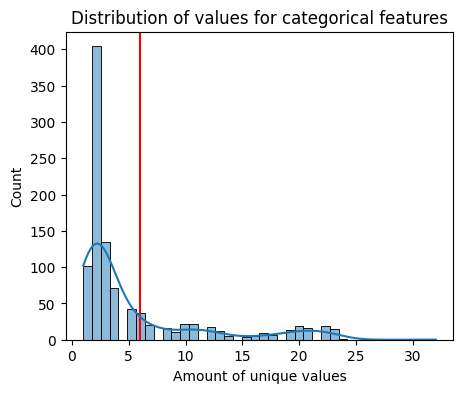

In [516]:
# plot distribution of unique values
uniques_per_column = string_stats.loc['unique']
#let's also calculate some quantile to the distribution plot
unq = np.quantile(uniques_per_column, q=0.75)
plt.figure(figsize=(5,4))
plt.title('Distribution of values for categorical features')
plt.xlabel('Amount of unique values')
plt.axvline(unq, color='red')
ax = sns.histplot(uniques_per_column, kde=True)

In [513]:
# find columns with top-5 by unique values
string_stats.loc['unique'].sort_values(ascending=False).head(5), train_df['c_1259'].unique()

(c_1259    32
 c_1374    24
 c_0965    23
 c_0523    23
 c_0434    23
 Name: unique, dtype: object,
 array(['n', 'e', 'w', 'm', 'p', 's', 'u', 'k', 'j', 'b', 'i', 'B', 'q',
        'a', 'h', 'G', 'c', 'd', 'C', 'v', 'y', 'D', 'o', 'l', 'A', 'z',
        't', 'r', 'F', 'x', 'g', 'f'], dtype=object))

In [514]:
from functools import reduce
# establish top K columns (by amount of unique strings) in dataframe
df_string_sample = string_stats.loc['unique'].sort_values(ascending=False).head(10).index
# extract unique values
df_string_sample_cols = [train_df[cn].dropna().unique() for cn in df_string_sample]
# compare, find intersection
reduce(np.intersect1d, df_string_sample_cols) # ~ map and accumulate

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'u', 'v', 'w'], dtype=object)

In [515]:
# list all possible unique values
pd.unique(string_part.values.ravel('K'))

array(['a', 'c', 'b', nan, 'd', 'e', 'f', 'i', 'h', 'k', 'm', 'g', 'r',
       's', 'o', 'j', 'l', 'q', 'p', 't', 'n', 'w', 'u', 'v', 'x', 'y',
       'B', 'G', 'C', 'D', 'A', 'z', 'F'], dtype=object)

## Float part
Contains 345 columns with a lot of missing values, only 4 columns have

Those NaNs are strongly ($\rho= 0.87$) correlated with float NaNs, i.e. used to come together

In [524]:
float_part = train_df.select_dtypes(include=['float64'])
float_part.describe()

,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,...,c_1072,c_1129,c_1148,c_1168,c_1230,c_1257,c_1277,c_1281,c_1308,c_1332
count,12.000000,388.000000,7662.000000,112.000000,58.000000,7658.000000,1348.000000,995.000000,5.000000,34.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.307692,0.655744,0.040935,0.102749,0.352874,0.395981,0.193175,0.012012,0.422222,0.129241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.245454,0.216399,0.024599,0.153007,0.209337,0.085000,0.236683,0.041382,0.395967,0.162008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.134615,0.428571,0.031974,0.011905,0.200000,0.342105,0.000000,0.000000,0.111111,0.015560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.307692,0.702381,0.041369,0.047619,0.283333,0.394737,0.200000,0.000000,0.444444,0.049793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.403846,0.857143,0.048950,0.142857,0.525000,0.421053,0.400000,0.011905,0.555556,0.186722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.846154,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,1.000000,1.000000,0.597510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


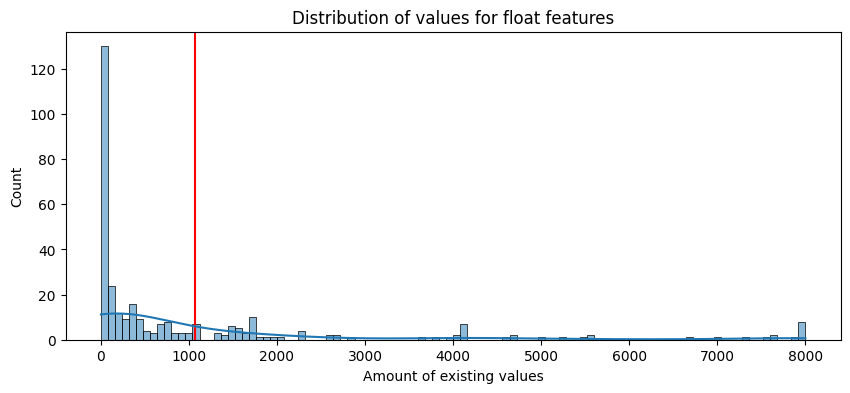

In [574]:
# plot distribution of existing values
existing_per_column = r.shape[0] - r.isna().sum(axis=0)
unqf = np.quantile(existing_per_column, q=0.75)
plt.figure(figsize=(10,4))
plt.title('Distribution of values for float features')
plt.xlabel('Amount of existing values')
plt.axvline(unqf, color='red')
ax = sns.histplot(existing_per_column, kde=True, bins=100)

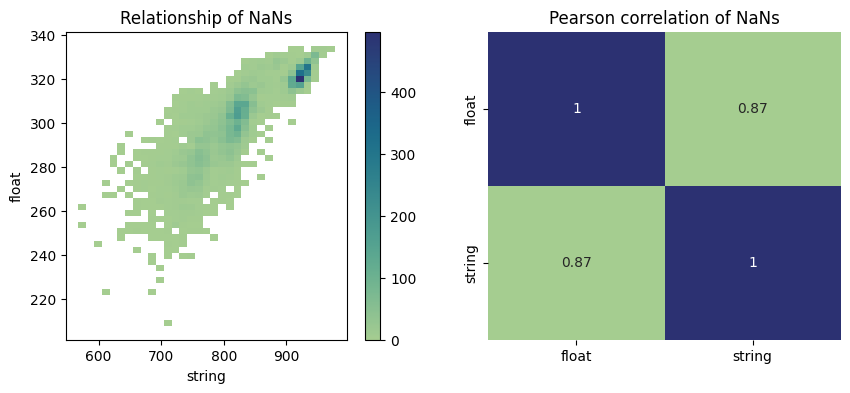

In [518]:
#NaN relationship
fig, ax = plt.subplots(1,2, figsize=(10,4)) 
rel = pd.concat([float_part.isna().sum(axis=1), string_part.isna().sum(axis=1)], axis=1)
ax[0].set_title('Relationship of NaNs')
ax[0].set_xlabel('string')
ax[0].set_ylabel('float')
ax[0] = sns.histplot(rel, x=1, y=0, cbar=True, cmap='crest', ax=ax[0])
ax[1].set_title('Pearson correlation of NaNs')
ax[1] = sns.heatmap(rel.corr(), cmap='crest', ax=ax[1], xticklabels=['float','string'], yticklabels=['float','string'], annot=True, cbar=False)
# h = sns.jointplot(rel, x=1, y=0, s=4)
# h.set_axis_labels('string NaNs', 'float NaNs')

## Preprocessing strategy

1) exclude id column
2) get rid of all-NaN columns
3) split the dataframe onto 3 parts by dtype
4) cast all strings to pandas categorical dtype and use ordinal encoder (pandas approach)
5) binning for numerical NaNs with #existing < threshold=?
6) median imputing for the rest, create an extra column for each feature with imputation

In [661]:
def base_preprocessing(dframe: pd.DataFrame, binning_thr=10) -> pd.DataFrame:
    # eliminate id column
    result_ = dframe.drop('id', axis=1)
    # get rid of columns with all NaNs
    allnan_cols = result_.columns[result_.isnull().all(axis=0)]
    result_.drop(allnan_cols, axis=1, inplace=True)
    # split by value type and treat string columns as categorical features
    int_part = result_.select_dtypes(include=['int64'])
    float_part = result_.select_dtypes(include=['float64'])
    string_part = result_.select_dtypes(include=['O']).astype('category')
    # handle the rest of NaNs 
    cat_part = string_part.apply(lambda col: col.cat.codes) # ~ ordinal encoding with all NaNs -> -1
    # split floats by a number of existing values
    existing = float_part.shape[0] - float_part.isna().sum(axis=0)
    float_to_bin = float_part.columns[existing < binning_thr]
    rest_float = float_part.columns[~(existing < binning_thr)]
    print(float_to_bin)
    return float_part

In [660]:
r = base_preprocessing(train_df)

Index(['n_0008', 'n_0011', 'n_0018', 'n_0055', 'n_0062', 'n_0065', 'n_0081',
       'n_0103', 'n_0111', 'o_0117', 'o_0121', 'o_0122', 'o_0126', 'o_0134',
       'o_0136', 'o_0149', 'o_0151', 'o_0161', 'o_0162', 'o_0164', 'o_0166',
       'o_0169', 'o_0171', 'o_0172', 'o_0174', 'o_0180', 'o_0182', 'o_0184',
       'o_0185', 'o_0186', 'o_0191', 'o_0192', 'o_0200', 'o_0203', 'o_0211',
       'o_0213', 'o_0218', 'o_0220', 'o_0225', 'o_0226', 'o_0233', 'o_0237',
       'o_0239', 'o_0242', 'o_0246', 'o_0250', 'o_0262', 'o_0263', 'o_0273',
       'o_0289', 'o_0290', 'o_0291', 'o_0294', 'o_0297', 'o_0299', 'o_0300',
       'o_0302', 'o_0306', 'o_0307', 'o_0309', 'o_0310', 'o_0311', 'o_0317',
       'o_0318', 'o_0320', 'o_0321'],
      dtype='object')


In [563]:
sum(r.isna().sum(axis=0) == 0)

4

In [623]:
r.columns[r.isna().sum(axis=0) > 1000]

Index(['n_0000', 'n_0001', 'n_0003', 'n_0004', 'n_0006', 'n_0007', 'n_0008',
       'n_0009', 'n_0010', 'n_0011',
       ...
       'o_0317', 'o_0318', 'o_0319', 'o_0320', 'o_0321', 'o_0322', 'o_0323',
       'o_0324', 'o_0325', 'o_0326'],
      dtype='object', length=302)

In [658]:
pd.qcut(r['n_0065'], q=1).unique()

[NaN, (-0.001, 0.0]]
Categories (1, interval[float64, right]): [(-0.001, 0.0]]

In [593]:
r.n_0000.unique()

array([       nan, 0.30769231, 0.07692308, 0.15384615, 0.46153846,
       0.61538462, 0.84615385, 0.        , 0.38461538])